In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from scipy.stats import qmc
from scipy.optimize import minimize, dual_annealing
from scipy.special import gamma
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


### Quadratic equation

In [2]:
def create_regression(m, variables, order, include_bias=True, return_non_poly=False):
    x = np.random.random((m, variables))*2-1
    poly = PolynomialFeatures(order, include_bias=include_bias)
    if return_non_poly:
        return poly.fit_transform(x), x
    return poly.fit_transform(x)


def nullspace(A, atol=1e-13, rtol=0):
    """
    input: A is the underdetermined linear system, shape = (m, n) where m is number of equations, and n is number of variables

    return: null space of A
    """
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns


def nd_cross(vectors):
    """
    input: vectors (n x n-1) where n is number of dimension, and n-1 is number of vectors

    return: a (n x 1) vector that is orthogonal to the input vectors
    """
    n = vectors.shape[0]
    assert n == vectors.shape[1] + 1, f"Input vector shape is incorrect. The number of columns ({vectors.shape[1]}) must be number of rows-1 ({n}-1={n-1})"

    cross_vector = np.zeros((n, 1))
    for i in range(n):
        basis = np.zeros((n, 1))
        basis[i] = 1
        cross_vector[i] = np.linalg.det(np.hstack((basis, vectors)))
    return cross_vector


def get_axes(theta_ln, Null):
    """
    Input: theta_ln is the first axes, Null is the null space, rank is the total number of axes required
    theta_ln shape = (n, 1) where n is number of dimensions/parameters
    Null shape = (n, DOF)

    Output: returns axes of the ellipse, shape = (n, rank), where rank = n - DOF
    the number of columns = rank number of axes, the first of which will be theta_ln, the others will be orthogonal to bothe theta_ln and columns of Null
    """
    n = len(theta_ln)
    #Theta = np.zeros((n, rank))
    #Theta[:, 0] = theta_ln

    # for numerical stability, each vector should be normalized to length 1
    orthogonals = np.hstack((Null, theta_ln))
    orthogonals /= np.linalg.norm(orthogonals, axis=0)
    for i in range(n-Null.shape[1]-1): # number of axes = rank (=n-DOF), number to generate = rank-1 since theta_ln is already 1 axis
        n_orthogonals = orthogonals.shape[1]
        axis = np.zeros((n, 1))
        axis[:n_orthogonals+1] = nd_cross(orthogonals[:n_orthogonals+1])
        axis /= np.linalg.norm(axis)
        orthogonals = np.hstack((orthogonals, axis))

    return orthogonals[:, Null.shape[1]:]

In [34]:
class EnsembleModel:
    def __init__(self, thetas, method='norm', weighting='recip', alpha=1):
        """
        Builds an ensemble model with thetas

        Initialize: 
        thetas: shape = (n, n_models), where n is number of parameters, and n_models is number of models samples
        method: the method for computing quality score of individual models, choose from 'norm', 'grad', 'var'
        weighting:: the method for weighting individual models using their quality score, choose from 'recip', 'negexp', 'neglog'

        Methods:
        EnsembleModel.predict(x)
        outputs the ensembled model prediction for x 
        """
        assert method in ['norm', 'grad', 'var'], "invalid method, only 'norm', 'grad', 'var' accepted"
        assert weighting in ['recip', 'negexp', 'invsqrt', 'neglog'], "invalid weighting, only 'recip', 'negexp', 'neglog' accepted"

        self.method = method
        self.weighting = weighting
        self.thetas = thetas
        self.alpha = alpha

        if self.method == 'norm':
            q = np.linalg.norm(thetas, axis=0)
            if self.weighting == 'recip':
                self.weights = 1/q**alpha

            elif self.weighting == 'negexp':
                self.weights = np.exp(-q*alpha)
            
            elif self.weighting == 'neglog':
                self.weights = -np.log(q**alpha)

            self.weights /= np.sum(self.weights)
            
    def predict(self, x):
        if self.method == 'norm':
            return x @ self.thetas @ self.weights

        else:
            if self.method == 'grad':
                # compute the magnitude of the gradient at x
                q = np.zeros((x.shape[0], self.thetas.shape[1]))
                for i, sample in enumerate(x):
                    for j, theta in enumerate(self.thetas.T):
                        q[i, j] = np.linalg.norm(sample * theta)

            elif self.method == 'var':
                #raise NotImplementedError
                q = np.zeros((x.shape[0], self.thetas.shape[1]))
                for i, sample in enumerate(x):
                    # generate neighbors of x
                    neighbors = np.random.normal(0, 1e-6, size=(100, x.shape[1])) + sample.reshape(1, -1)
                    neighbors = neighbors @ self.thetas
                    q[i, :] = np.var(neighbors, axis=0)
            
            if self.weighting == 'recip':
                self.weights = np.exp(-np.log(q)*self.alpha) #1/q**self.alpha

            elif self.weighting == 'negexp':
                self.weights = np.exp(-q*self.alpha)
            
            elif self.weighting == 'neglog':
                self.weights = -np.log(q**self.alpha)

            # normalize the weights across all models for each sample in x, i.e rows add up to 1
            self.weights /= np.sum(self.weights, axis=1).reshape(-1,1)

            # predict on x with thetas, apply the individual weights of each model for each sample
            return np.sum((x @ self.thetas) * self.weights, axis=1)

In [4]:
# define a some samples for training
# m: number of samples
# n: number of features

m = 7
variables = 1
order = 25
include_bias = True
noise = 0.3

if variables == 1:
    x, x_order1 = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x = create_regression(m, variables, order, include_bias=include_bias)
n = x.shape[1]
# x = np.random.random((m, n))*2-1
theta_true = np.random.random((n ,1))*2-1
y = x @ theta_true + np.random.normal(0, noise, (m, 1))

print(f"m: {m}, n: {n}, DOF: {n-m}, rank: {np.linalg.matrix_rank(x)}, Nullspace cols: {nullspace(x).shape[1]}")

m: 7, n: 26, DOF: 19, rank: 7, Nullspace cols: 19


### Solving under-determined system
1. solve for the least norm solution, thete_ln with pseudo-inverse of x

2. find vectors, theta_sol that line on the solution line/plane, and find the orthogonal vectors to both theta_ln and theta_sol
    * 2.a the columns of the nullspace of x are vectors that lie on the solution line/plane
    * 2.b obtain orthogonal vectors, theta_orth with cross product between theta_ln and theta_sol

3. transform system into lower dimension in the basis of Theta, which consists of theta_orth and theta_ln. i.e.:
    * original loss function: L = theta.T A theta + b theta + c0
    * new loss function: L = alpha.T Theta.T A Theta alpha + b Theta alpha + c0
    * new loss function: L = alpha.T A_reduced alpha + b_reduced alpha + c0, where A_reduced = Theta.T A Theta; and b_reduced = b Theta

4. sample solutions in the lower dimenions space w.r.t. alpha using the ellipse method

5. transform alpha back to theta by theta = Theta alpha

In [5]:
# 1. minimum norm solution
theta_ln = np.linalg.pinv(x) @ y

In [6]:
# 2. find Theta
Theta = get_axes(theta_ln, nullspace(x))
#Theta = nd_cross(np.hstack((nullspace(x), theta_ln)))
#Theta = np.cross(nullspace(x).reshape(-1), theta_ln.reshape(-1)).reshape(-1, 1)
#Theta = np.hstack((Theta, theta_ln))
print(Theta)

[[ 1.93347928e-02  2.35822945e-01  9.69983516e-01  1.78490804e-02
  -4.66976954e-02  1.58446818e-02 -7.96708906e-03]
 [ 1.87042443e-01  7.75596210e-01 -1.87522434e-01 -5.28609384e-01
   1.63354122e-02  1.46652548e-01 -7.39077637e-02]
 [ 1.11376590e-01 -5.12654937e-01  1.01709555e-01 -5.75876191e-01
  -4.14591265e-01  3.04393324e-01 -1.41357173e-01]
 [-5.30246443e-01  2.53545231e-01 -8.46079270e-02  1.63672499e-01
  -6.92029837e-01  6.68689834e-02  7.30156130e-03]
 [-1.32791988e-01 -1.13508601e-01  6.21040363e-02 -5.09273087e-01
   1.00290184e-01 -1.94900073e-01  1.43666248e-01]
 [ 2.81049548e-01  4.85619036e-02 -4.12585456e-02  1.07628291e-01
  -4.99745831e-01 -1.14025317e-01  8.48088259e-02]
 [-4.03414921e-01 -2.02889748e-02  2.47082791e-02 -2.65271711e-01
   4.14569595e-02 -3.07604016e-01  1.72269785e-01]
 [ 4.26813112e-01  8.35538654e-03 -1.44229023e-02  2.33100233e-02
  -2.54152877e-01 -2.44375177e-01  1.10609324e-01]
 [-2.69532621e-01 -3.40789062e-03  7.80311461e-03 -1.23978447e-0

In [7]:
# 3. transform system into lower dimension
A = x.T @ x
b = -2* y.T @ x
c0 = y.T @ y

A_reduced = Theta.T @ A @ Theta
b_reduced = b @ Theta

In [8]:
# 4. ellipse method

# center & eigendecomposition of A
theta_c = (-0.5 * b_reduced @ np.linalg.inv(A_reduced)).reshape(-1, 1)
Lambda, Q = np.linalg.eig(A_reduced)
Lambda = np.where(Lambda < 0, 0, Lambda)

# solve ellipse equation given some u value, u_min should be 0 given that it's an underdetermined system
u_min = theta_c.T @ A_reduced @ theta_c + b_reduced @ theta_c + c0
u_min = u_min.item()
if u_min < 0:  # numerical issues where u_min=0 is computed as a very small negative value
    u_min = 0

# calculate K given some u_star
#u_star = 1.3
u_star = np.linalg.norm(theta_ln) * 0.69
c = c0 - u_star
K = Lambda/(theta_c.T @ A_reduced @ theta_c - c)
K = K.reshape(-1)

In [9]:
u_star

74.42036473753757

In [10]:
# samples on a unit sphere
n_models = 100
sample_n = Theta.shape[1]
alpha_samples = np.random.normal(0, np.ones(sample_n), size=(n_models, sample_n))
l1 = np.linalg.norm(alpha_samples, axis=1)
alpha_samples = alpha_samples/l1.reshape(-1, 1)

# get tangents of the sample points. There needs to be n-1 tangents for a n-d point
tangent = np.zeros((len(alpha_samples), sample_n-1, sample_n))
for t_i in range(1, sample_n):
    tangent[:, t_i-1, 0] = alpha_samples[:, t_i]
    tangent[:, t_i-1, t_i] = -alpha_samples[:, 0]
tangent_o = tangent.copy()

# transform from sphere to ellipse
alpha_samples = alpha_samples @ np.diag(np.sqrt(1/K))
tangent = tangent @ np.diag(np.sqrt(1/K))

# calculate contraction of local area around sample after transformation
contract = np.sqrt(np.linalg.det((tangent @ tangent.transpose(0, 2, 1))))
contract = contract/np.sqrt(np.linalg.det((tangent_o @ tangent_o.transpose(0, 2, 1))))
contract = np.nan_to_num(contract)

# rejection sampling
p = contract/np.max(contract)
choose = np.random.binomial(1, p, size=len(p)).astype(bool)
alpha_samples = alpha_samples[choose]

# rotate according to eigenvectors and shift back to center
alpha_samples = (Q @ alpha_samples.T + theta_c)

In [11]:
# 5. transform from alpha back to theta
theta_samples = Theta @ alpha_samples
theta_samples.shape

(26, 46)

In [12]:
# check that all theta_samples does indeed give the correct losses
print(f"calculated loss of all samples: {np.sum((x @ theta_samples - y)**2, axis=0)}")
print(f"loss that was defined for sample: {u_star}, check that they are equal")

calculated loss of all samples: [74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474 74.42036474
 74.42036474 74.42036474 74.42036474 74.42036474]
loss that was defined for sample: 74.42036473753757, check that they are equal


In [13]:
# visualize to make sure it makes sense
#%matplotlib widget
if n == 3 and sample_n == 2:
    fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(theta_samples[0], theta_samples[1], theta_samples[2], marker='.')
    ax.scatter([0], [0], [0], marker='.', s=5)
    ax.scatter(theta_ln[0], theta_ln[1], theta_ln[2], marker='*', s=5, c='black')
    sol_line_length = 15
    sol_line_start = theta_ln + sol_line_length*nullspace(x)
    sol_line_end = theta_ln - sol_line_length*nullspace(x)
    ax.plot([sol_line_start[0], sol_line_end[0]], [sol_line_start[1], sol_line_end[1]], [sol_line_start[2], sol_line_end[2]])
    ax.plot([0, theta_ln[0].item()], [0, theta_ln[1].item()], [0, theta_ln[2].item()])

    max_radius = np.max(theta_samples)
    for axis in 'xyz':
        getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
    plt.show()

In [14]:
alpha = 0.1
LS = linear_model.LinearRegression(fit_intercept=include_bias)
LS.fit(x, y)
lasso = linear_model.Lasso(alpha=alpha, fit_intercept=include_bias)
lasso.fit(x, y)
ridge = linear_model.Ridge(alpha=alpha, fit_intercept=include_bias)
ridge.fit(x, y)
elasticnet = linear_model.ElasticNet(alpha=alpha, fit_intercept=include_bias)
elasticnet.fit(x, y)

if variables == 1:
    x_test, x_test_order1 = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x_test = create_regression(100, variables, order, include_bias=include_bias)

#x_test = np.random.random((100, n))*2-1
y_test = x_test @ theta_true
y_pred_LS = LS.predict(x_test)
weighting = 'recip'
em1 = EnsembleModel(theta_samples, method='norm', weighting=weighting, alpha=2)
em2 = EnsembleModel(theta_samples, method='grad', weighting=weighting, alpha=2)
em3 = EnsembleModel(theta_samples, method='var', weighting=weighting, alpha=2)
em_random = EnsembleModel(np.random.normal(0, np.std(theta_samples, axis=0), size=theta_samples.shape), method='grad')
y_pred_FEO_ensemble1 = em1.predict(x_test)
y_pred_FEO_ensemble2 = em2.predict(x_test)
y_pred_FEO_ensemble3 = em3.predict(x_test)
y_pred_FEO_ensemble_rand = em_random.predict(x_test)
y_pred_L1 = lasso.predict(x_test)
y_pred_L2 = ridge.predict(x_test)
y_pred_L1L2 = elasticnet.predict(x_test)

MSE for LS prediction: 969.8638842438254
MSE for L1 prediction: 0.03411016346014202
MSE for L2 prediction: 0.08280287219967988
MSE for L1 + L2 prediction: 0.03517519154734206
MSE for FEO prediction (ensemble by norm): 54.14304944759556
MSE for FEO prediction (ensemble by grad): 52.656199922874755
MSE for FEO prediction (ensemble by var): 132.5725054069636
MSE for FEO prediction (ensemble by norm random): 252.12044318646585


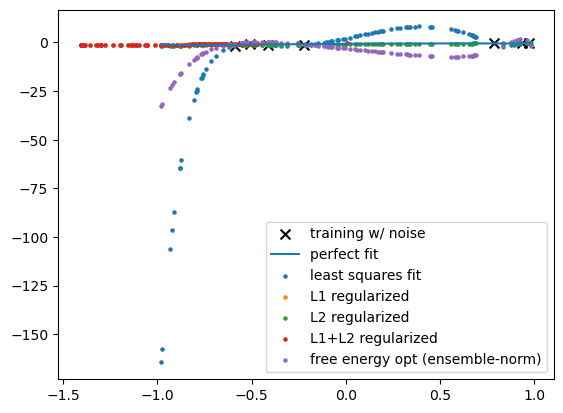

In [16]:
print(f"MSE for LS prediction: {mean_squared_error(y_test, y_pred_LS)}")
print(f"MSE for L1 prediction: {mean_squared_error(y_test, y_pred_L1)}")
print(f"MSE for L2 prediction: {mean_squared_error(y_test, y_pred_L2)}")
print(f"MSE for L1 + L2 prediction: {mean_squared_error(y_test, y_pred_L1L2)}")
print(f"MSE for FEO prediction (ensemble by norm): {mean_squared_error(y_test, y_pred_FEO_ensemble1)}")
print(f"MSE for FEO prediction (ensemble by grad): {mean_squared_error(y_test, y_pred_FEO_ensemble2)}")
print(f"MSE for FEO prediction (ensemble by var): {mean_squared_error(y_test, y_pred_FEO_ensemble3)}")
print(f"MSE for FEO prediction (ensemble by norm random): {mean_squared_error(y_test, y_pred_FEO_ensemble_rand)}")

if variables == 1:
    plt.scatter(x_order1, y, s=50, marker='x', color='black', label='training w/ noise')
    x_test_order1_ind = np.argsort(x_test_order1.reshape(-1))
    plt.plot(x_test_order1[x_test_order1_ind], x_test[x_test_order1_ind] @ theta_true, label='perfect fit')
    plt.scatter(x_test_order1, y_pred_LS, s=5, label="least squares fit")
    plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(x_test_order1, y_pred_L2, s=5, label='L2 regularized')
    plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(x_test_order1, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble-norm)")
else:
    plt.scatter(y, x @ theta_true, s=10, marker='x', color='black', label='training')
    plt.plot(y_test, y_test, label='perfect fit')
    plt.scatter(y_test, y_pred_LS, s=5, label="least squares fit")
    plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(y_test, y_pred_L2, s=5, label='L2 regularized')
    plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(y_test, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble)")
plt.legend()

## Actual implementation

In [17]:
class FEO:
    def __init__(self, temperature, L2_regularized=False, w=0.1):
        self.temp = temperature
        self.L2_regularized = L2_regularized
        self.w = w
        self.fitted = False
    
    def fit(self, x, y, fixed_u_star=False, u_star_mul=1.5):
        m = x.shape[0]
        n = x.shape[1]
        self.m = m
        self.n = n
        assert m == len(y), f"length of y ({len(y)}) must match length of x ({m})"
        A = x.T @ x
        if self.L2_regularized:
            A += self.w*np.eye(len(A))
            
        rank = np.linalg.matrix_rank(A)
        self.rank = rank
        if rank < n:
            self._fit_underdetermined(x, y, rank, A, fixed_u_star, u_star_mul)
        else:
            self._fit_determined(x, y, n, A, fixed_u_star, u_star_mul)

    def _get_conics(self, n, A, b, c0):
        # center & eigendecomposition of A
        theta_c = (-0.5 * b @ np.linalg.inv(A)).reshape(-1, 1)
        Lambda, Q = np.linalg.eig(A)
        Lambda = np.real_if_close(Lambda, tol=1e-15)

        # solve ellipse equation given some u value 
        u_min = theta_c.T @ A @ theta_c + b @ theta_c + c0
        u_min = u_min.item()
        if u_min < 0:  # numerical issues where u_min=0 is computed as a very small negative value
            u_min = 0

        # calculate scaling factor for circumference with respect to u^((n-1)/2)
        u_ = 1
        axes = Lambda/(theta_c.T @ A @ theta_c - (c0 - (u_min + u_)))
        axes = (np.sqrt(1/axes)).reshape(-1)

        c_ = self._circumference(axes, len(axes))
        factor = c_/u_**((n-1)/2)

        self.A = A
        self.b = b
        self.c0 = c0
        self.u_min = u_min
        self.factor = factor
        self.theta_c = theta_c
        self.Lambda = Lambda
        self.Q = Q

    def _fit_determined(self, x, y, n, A, fixed_u_star, u_star_mul):
        b = -2* y.T @ x
        c0 = y.T @ y
        self._get_conics(n, A, b, c0)

        # calculate the optimal u value, u_star for given temperature
        if fixed_u_star:
            #u_star = np.linalg.norm(self.theta_c) * u_star_mul
            u_star = u_star_mul #self.u_min * u_star_mul
        else:
            u_star = self.temp * self.factor * (n-1)/2
        if u_star < self.u_min + 1e-6: 
            u_star = self.u_min + 1e-6 

        c = self.c0 - u_star
        K = self.Lambda/(self.theta_c.T @ A @ self.theta_c - c)
        K = K.reshape(-1)

        self.c = c
        self.u_star = u_star
        self.K = K
        self.fitted = True
    
    def _fit_underdetermined(self, x, y, rank, A, fixed_u_star, u_star_mul):
        b = -2* y.T @ x
        c0 = y.T @ y
        
        theta_ln = np.linalg.pinv(x) @ y
        Theta = self._get_axes(theta_ln, self._nullspace(x))

        A_reduced = Theta.T @ A @ Theta
        b_reduced = b @ Theta

        self._get_conics(rank, A_reduced, b_reduced, c0)

        if fixed_u_star:
            #u_star = np.linalg.norm(theta_ln) * u_star_mul
            u_star = u_star_mul
        else:
            u_star = self.temp * self.factor * (rank-1)/2
        if u_star < 1e-6: 
            u_star = 1e-6 

        c = self.c0 - u_star
        K = self.Lambda/(self.theta_c.T @ A_reduced @ self.theta_c - c)
        K = K.reshape(-1)

        self.u_min = 0
        self.u_star = u_star
        self.c = c
        self.K = K
        self.Theta = Theta
        self.fitted = True

    def predict(self, x, n_models=100):
        if not self.fitted:
            print("Model not fitted yet!")
            return
        
        theta_samples = self._sample(n_models)
        self.theta_samples = theta_samples
        y_pred_FEO = x @ theta_samples
        return y_pred_FEO

    def _sample(self, n_models):
        if self.rank < self.n:
            sample_n = self.rank
        else:
            sample_n = self.n

        # samples on a unit sphere
        theta_samples = np.random.normal(0, np.ones(sample_n), size=(n_models, sample_n))
        l1 = np.linalg.norm(theta_samples, axis=1)
        theta_samples = theta_samples/l1.reshape(-1, 1)

        # get tangents of the sample points. There needs to be n-1 tangents for a n-d point
        tangent = np.zeros((len(theta_samples), sample_n-1, sample_n))
        for t_i in range(1, sample_n):
            tangent[:, t_i-1, 0] = theta_samples[:, t_i]
            tangent[:, t_i-1, t_i] = -theta_samples[:, 0]
        tangent_o = tangent.copy()

        # transform from sphere to ellipse
        theta_samples = theta_samples @ np.diag(np.sqrt(1/self.K))
        tangent = tangent @ np.diag(np.sqrt(1/self.K))

        # calculate contraction of local area around sample after transformation
        contract = np.sqrt(np.linalg.det((tangent @ tangent.transpose(0, 2, 1))))
        contract = contract/np.sqrt(np.linalg.det((tangent_o @ tangent_o.transpose(0, 2, 1))))
        contract = np.nan_to_num(contract)
        
        # rejection sampling
        p = contract/np.max(contract)
        choose = np.random.binomial(1, p, size=len(p)).astype(bool)
        theta_samples = theta_samples[choose]

        # rotate according to eigenvectors and shift back to center
        #theta_samples = theta_samples @ self.Q + self.theta_c.reshape(1, -1)
        theta_samples = (self.Q @ theta_samples.T + self.theta_c)
        
        if self.rank < self.n:
            theta_samples = self.Theta @ theta_samples

        return theta_samples

    def _double_factorial(self, n):
        result = 1
        for i in range(n, 0, -2):
            result *= i
        return result

    def _circumference(self, a, n):
        if n%2 == 0:
            D = np.pi/2 * self._double_factorial(n-1) / self._double_factorial(n-2)
        else:
            D = self._double_factorial(n-1) / self._double_factorial(n-2)
        p = np.log(n)/np.log(D)
        H = ((np.prod(a)**p)*(np.sum(a**(-p))/n))**(1/p)
        return 2*np.pi**(n/2)*H/gamma(n/2)
    
    def _nd_cross(self, vectors):
        """
        input: vectors (n x n-1) where n is number of dimension, and n-1 is number of vectors

        return: a (n x 1) vector that is orthogonal to the input vectors
        """
        n = vectors.shape[0]
        assert n == vectors.shape[1] + 1, f"Input vector shape is incorrect. The number of columns ({vectors.shape[1]}) must be number of rows-1 ({n}-1={n-1})"

        cross_vector = np.zeros((n, 1))
        for i in range(n):
            basis = np.zeros((n, 1))
            basis[i] = 1
            cross_vector[i] = np.linalg.det(np.hstack((basis, vectors)))
        return cross_vector

    def _get_axes(self, theta_ln, Null):
        """
        Input: theta_ln is the first axes, Null is the null space, rank is the total number of axes required
        theta_ln shape = (n, 1) where n is number of dimensions/parameters
        Null shape = (n, DOF)

        Output: returns axes of the ellipse, shape = (n, rank), where rank = n - DOF
        the number of columns = rank number of axes, the first of which will be theta_ln, the others will be orthogonal to bothe theta_ln and columns of Null
        """
        n = len(theta_ln)
        #Theta = np.zeros((n, rank))
        #Theta[:, 0] = theta_ln

        # for numerical stability, each vector should be normalized to length 1
        orthogonals = np.hstack((Null, theta_ln))
        orthogonals /= np.linalg.norm(orthogonals, axis=0)
        for i in range(n-Null.shape[1]-1): # number of axes = rank (=n-DOF), number to generate = rank-1 since theta_ln is already 1 axis
            n_orthogonals = orthogonals.shape[1]
            axis = np.zeros((n, 1))
            axis[:n_orthogonals+1] = nd_cross(orthogonals[:n_orthogonals+1])
            axis /= np.linalg.norm(axis)
            orthogonals = np.hstack((orthogonals, axis))

        return orthogonals[:, Null.shape[1]:]

    def _nullspace(self, A, atol=1e-13, rtol=0):
        """
        input: A is the underdetermined linear system, shape = (m, n) where m is number of equations, and n is number of variables

        return: null space of A
        """
        A = np.atleast_2d(A)
        u, s, vh = np.linalg.svd(A)
        tol = max(atol, rtol * s[0])
        nnz = (s >= tol).sum()
        ns = vh[nnz:].conj().T
        return ns

In [18]:
# define a some samples for training
# m: number of samples
# n: number of features

m = 3
variables = 1
order = 5
include_bias = True
#n = 5
noise = 0.2

if variables == 1:
    x, x_order1 = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x = create_regression(m, variables, order, include_bias=include_bias)
n = x.shape[1]
# x = np.random.random((m, n))*2-1
theta_true = np.random.random((n ,1))*2-1
y = x @ theta_true + np.random.normal(0, noise, (m, 1))


print(f"Info about problem: \nm: {m}, n: {n}, DOF: {max(0, n-m)}, rank: {np.linalg.matrix_rank(x)}, Nullspace cols: {nullspace(x).shape[1]}")

Info about problem: 
m: 3, n: 6, DOF: 3, rank: 3, Nullspace cols: 3


In [19]:
# check that sampled models give the correct training loss as required (u_star)
temperature = 1e-13
fixed_u_star = True
u_star_mul = np.sum(y**2) #n #0.69 #
L2_regularized = False

feo = FEO(temperature, L2_regularized=L2_regularized)
feo.fit(x, y, fixed_u_star=fixed_u_star, u_star_mul=u_star_mul)
y_pred_train_feo = feo.predict(x, 50)
if L2_regularized:
    print(np.mean(np.sum((y_pred_train_feo - y)**2, axis=0) + 0.1*np.linalg.norm(feo.theta_samples,axis=0)**2))
else:
    print(np.mean(np.sum((y_pred_train_feo - y)**2, axis=0)))
print(feo.u_star)
print(feo.u_min)

2.012008467846852
2.0120084678468535
0


In [20]:
alpha = 0.1
feo = FEO(temperature, L2_regularized=L2_regularized)
#feo.fit(x, y)
feo.fit(x, y, fixed_u_star=fixed_u_star, u_star_mul=u_star_mul)
LS = linear_model.LinearRegression(fit_intercept=include_bias)
LS.fit(x, y)
lasso = linear_model.Lasso(alpha=alpha, fit_intercept=include_bias)
lasso.fit(x, y)
ridge = linear_model.Ridge(alpha=alpha, fit_intercept=include_bias)
ridge.fit(x, y)
elasticnet = linear_model.ElasticNet(alpha=alpha, fit_intercept=include_bias)
elasticnet.fit(x, y)

if variables == 1:
    x_test, x_test_order1 = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x_test = create_regression(100, variables, order, include_bias=include_bias)

y_test = x_test @ theta_true
y_pred_LS = LS.predict(x_test)
y_pred_FEO = feo.predict(x_test, 50)
thetas = feo._sample(50)

weighting = 'recip'
weighting_alpha = 3
em1 = EnsembleModel(thetas, method='norm', weighting=weighting, alpha=weighting_alpha)
em2 = EnsembleModel(thetas, method='grad', weighting=weighting, alpha=weighting_alpha)
em3 = EnsembleModel(thetas, method='var', weighting=weighting, alpha=weighting_alpha)
theta_rand = np.random.normal(0, np.std(thetas, axis=0), size=thetas.shape)
em_random_norm = EnsembleModel(theta_rand, method='norm', weighting=weighting)
em_random_grad = EnsembleModel(theta_rand, method='grad', weighting=weighting)
em_random_var = EnsembleModel(theta_rand, method='var', weighting=weighting)

y_pred_FEO_ensemble1 = em1.predict(x_test)
y_pred_FEO_ensemble2 = em2.predict(x_test)
y_pred_FEO_ensemble3 = em3.predict(x_test)
y_pred_FEO_ensemble_rand1 = em_random_norm.predict(x_test)
y_pred_FEO_ensemble_rand2 = em_random_grad.predict(x_test)
y_pred_FEO_ensemble_rand3 = em_random_var.predict(x_test)
y_pred_L1 = lasso.predict(x_test)
y_pred_L2 = ridge.predict(x_test)
y_pred_L1L2 = elasticnet.predict(x_test)

MSE for LS prediction: 0.08386753398984012
MSE for L1 prediction: 0.08300899446875847
MSE for L2 prediction: 0.06786969675238938
MSE for L1 + L2 prediction: 0.06124242279463992
MSE for FEO prediction (ensemble by norm): 0.18687632717375052
MSE for FEO prediction (ensemble by grad): 0.19743349163491253
MSE for FEO prediction (ensemble by var): 0.2393822682337792


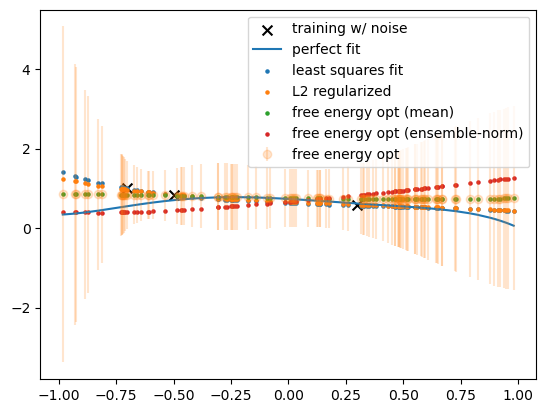

In [21]:
print(f"MSE for LS prediction: {mean_squared_error(y_test, y_pred_LS)}")
print(f"MSE for L1 prediction: {mean_squared_error(y_test, y_pred_L1)}")
print(f"MSE for L2 prediction: {mean_squared_error(y_test, y_pred_L2)}")
print(f"MSE for L1 + L2 prediction: {mean_squared_error(y_test, y_pred_L1L2)}")
#print(f"MSE for FEO prediction (mean): {mean_squared_error(y_test, np.mean(y_pred_FEO, axis=1))}")
#print(f"MSE for FEO prediction (median): {mean_squared_error(y_test, np.median(y_pred_FEO, axis=1))}")
#print(f"MSE for FEO prediction (mean of models): {np.mean(np.sum((y_pred_FEO - y_test)**2, axis=0)/len(y_test))}")
#print(f"MSE for FEO prediction (best of models): {np.min(np.sum((y_pred_FEO - y_test)**2, axis=0)/len(y_test))}")
print(f"MSE for FEO prediction (ensemble by norm): {mean_squared_error(y_test, y_pred_FEO_ensemble1)}")
print(f"MSE for FEO prediction (ensemble by grad): {mean_squared_error(y_test, y_pred_FEO_ensemble2)}")
print(f"MSE for FEO prediction (ensemble by var): {mean_squared_error(y_test, y_pred_FEO_ensemble3)}")
# print(f"MSE for FEO prediction (ensemble by norm random): {mean_squared_error(y_test, y_pred_FEO_ensemble_rand1)}")
# print(f"MSE for FEO prediction (ensemble by grad random): {mean_squared_error(y_test, y_pred_FEO_ensemble_rand2)}")
# print(f"MSE for FEO prediction (ensemble by var random): {mean_squared_error(y_test, y_pred_FEO_ensemble_rand3)}")


%matplotlib inline
if variables == 1:
    plt.scatter(x_order1, y, s=50, marker='x', color='black', label='training w/ noise')
    x_test_order1_ind = np.argsort(x_test_order1.reshape(-1))
    plt.plot(x_test_order1[x_test_order1_ind], x_test[x_test_order1_ind] @ theta_true, label='perfect fit')
    plt.scatter(x_test_order1, y_pred_LS, s=5, label="least squares fit")
    #plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(x_test_order1, y_pred_L2, s=5, label='L2 regularized')
    #plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(x_test_order1, np.mean(y_pred_FEO, axis=1), s=5, label="free energy opt (mean)")
    plt.scatter(x_test_order1, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble-norm)")
    plt.errorbar(x_test_order1, np.mean(y_pred_FEO, axis=1), yerr=np.std(y_pred_FEO, axis=1), fmt="o", alpha=0.2, label="free energy opt")
else:
    plt.scatter(y, x @ theta_true, s=10, marker='x', color='black', label='training')
    plt.plot(y_test, y_test, label='perfect fit')
    plt.scatter(y_test, y_pred_LS, s=5, label="least squares fit")
    #plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(y_test, y_pred_L2, s=5, label='L2 regularized')
    #plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(y_test, np.mean(y_pred_FEO, axis=1), s=5, label="free energy opt")
    plt.scatter(y_test, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble)")
    plt.errorbar(y_test, np.mean(y_pred_FEO, axis=1), yerr=np.std(y_pred_FEO, axis=1), fmt="o", alpha=0.2, label="free energy opt")
plt.legend()

In [73]:

losses = pd.DataFrame(columns=["m", "test_loss", "model"])

variables = 4
order = 2
include_bias = True
noise = 0.6
n = create_regression(m, variables, order, include_bias=include_bias).shape[1]

ms = np.unique((n*np.arange(0.2, 1, 0.2)).astype(int))
ms = ms[ms>=2]
#ms = [n]
temperatures = [0.01]#, 0.05, 0.1, 0.5, 1, 5, 10]
replicates = 100

for m in tqdm(ms):
    for i in range(replicates):
        x = create_regression(m, variables, order, include_bias=include_bias)
        theta_true = np.random.random((n ,1))*2-1
        gaussian_noise = np.random.normal(0, noise, (m, 1))
        y = x @ theta_true + gaussian_noise
        if m == n:
            remove = np.random.choice(m)
            #remove = np.argmax(gaussian_noise.reshape(-1))
            x = x[np.arange(m) != remove]
            y = y[np.arange(m) != remove]

        LS = linear_model.LinearRegression(fit_intercept=include_bias)
        LS.fit(x, y)
        ridge = linear_model.Ridge(alpha=alpha, fit_intercept=include_bias)
        ridge.fit(x, y)

        x_test = create_regression(100, variables, order, include_bias=include_bias)
        y_test = x_test @ theta_true
        y_pred_LS = LS.predict(x_test)
        y_pred_L2 = ridge.predict(x_test)

        feo = FEO(temperature, L2_regularized=False, w=alpha)
        feo.fit(x, y, fixed_u_star=True, u_star_mul=np.sum((x@theta_true - y)**2))#0.69)
        thetas = feo._sample(500)
        weighting = 'recip'
        weighting_alpha = max(2*max(n-np.abs(n-m)-2, 0), 1)
        
        em1 = EnsembleModel(thetas, method='norm', weighting=weighting, alpha=weighting_alpha)
        em2 = EnsembleModel(thetas, method='grad', weighting=weighting, alpha=weighting_alpha)
        em3 = EnsembleModel(thetas, method='var', weighting=weighting, alpha=weighting_alpha)

        y_pred_FEO_1 = em1.predict(x_test)
        y_pred_FEO_2 = em2.predict(x_test)
        y_pred_FEO_3 = em3.predict(x_test)


        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_LS)], "model":"LS"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_L2)], "model":"L2"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_1)], "model":f"FEO_norm"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_2)], "model":f"FEO_grad"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_3)], "model":f"FEO_var"})], ignore_index=True)
    


100%|██████████| 4/4 [00:51<00:00, 12.82s/it]


Text(0, 0.5, 'weight to high quality models')

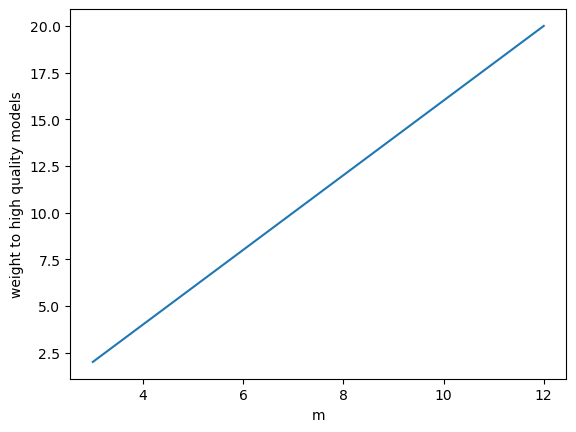

In [74]:
weighting_alpha = []
for m in ms:
    weighting_alpha.append(max(2*max(n-np.abs(n-m)-2, 0), 1))
plt.plot(ms, weighting_alpha)
plt.xlabel("m")
plt.ylabel("weight to high quality models")

In [75]:
losses_filt = losses[(losses['model'] != 'FEO_var') & (losses['model'] != 'FEO_grad')]

In [76]:
losses_filt

,m,test_loss,model
0,3,0.537063,LS
1,3,0.530331,L2
2,3,0.506416,FEO_norm
5,3,1.336736,LS
6,3,1.317747,L2
...,...,...,...
1991,12,0.494596,L2
1992,12,0.525473,FEO_norm
1995,12,44.356432,LS
1996,12,0.843559,L2


Text(0.5, 1.0, 'Test loss against size of training set (m) for 15-dimension linear regression')

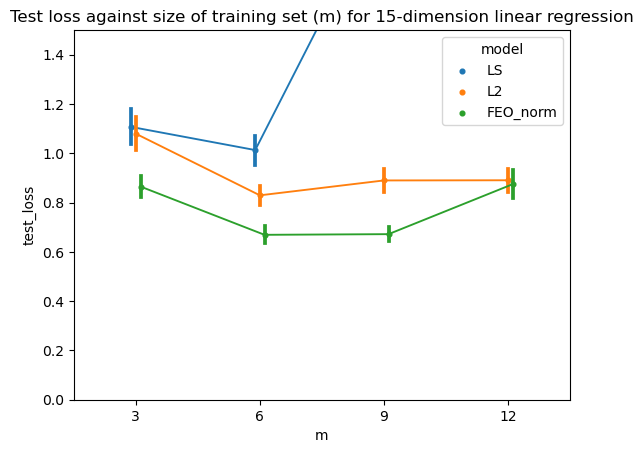

In [78]:
fig, ax = plt.subplots()
plot = sns.pointplot(data=losses_filt, x='m', y='test_loss', hue='model', scale = 0.5, errorbar='se', dodge=True, ax=ax)
ax.set_ylim(0, 1.5)
plt.title(f"Test loss against size of training set (m) for {n}-dimension linear regression")

### Model entropy RANSAC

In [991]:
variables = 1
order = 2
include_bias = True
noise = 0.2
m = 3
x, x_ = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
n = x.shape[1]
theta_true = np.random.random((n ,1))*2-1
y = x @ theta_true
#y += np.random.normal(0, noise, (m, 1))
outlier = np.random.choice(m)
y[outlier] += np.random.normal(0, noise)

x = x[np.argsort(x_.reshape(-1))]
y = y[np.argsort(x_.reshape(-1))]
x_ = x_[np.argsort(x_.reshape(-1))]

outlier is : 2
[428.51533057 428.51533057 428.51533057]


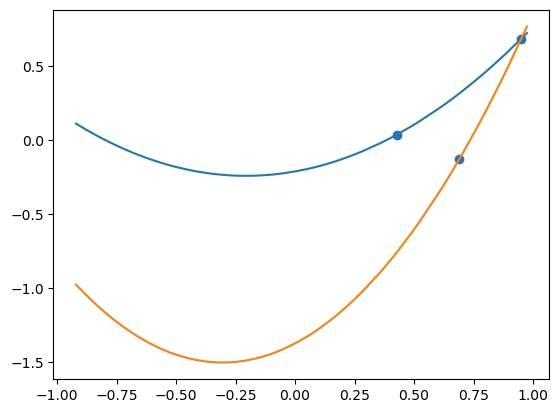

In [992]:
from itertools import combinations

# Idea 1: 
# - random subset of data. For each subset, calculate entropy at fixed loss
# - choose to remove dataset that result in low entropy

# get subset of training data
print(f"outlier is : {outlier}")

subsets = list(combinations(list(range(m)), n))
entropy = np.zeros(m)

for subset in subsets:
    feo = FEO(temperature, L2_regularized=False)
    feo.fit(x[subset, :], y[subset, :], fixed_u_star=fixed_u_star, u_star_mul=0.01)
    entropy[[subset]] += feo.factor

print(entropy)

plt.scatter(x_, y)
w, w_ = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
v = w @ theta_true
plt.plot(w_[np.argsort(w_.reshape(-1))], v[np.argsort(w_.reshape(-1))], label='perfect fit')

LS = linear_model.LinearRegression(fit_intercept=include_bias)
LS.fit(x[np.argsort(entropy)[1:], :], y[np.argsort(entropy)[1:], :])
plt.plot(w_[np.argsort(w_.reshape(-1))], LS.predict(w)[np.argsort(w_.reshape(-1))])

outlier is : 2
[0.03453878 0.03453878 0.03453878]


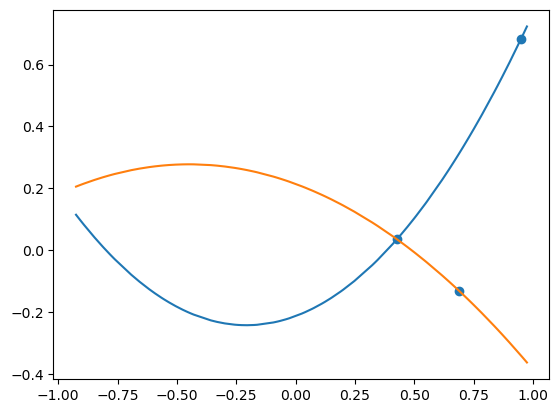

In [993]:
# Idea 2: 
# - random subset of data. Fit model and calculate loss over whole dataset
# - calculate entropy with the loss
# - choose to remove dataset with low entropy

# get subset of training data
print(f"outlier is : {outlier}")

temp = 1e-3
entropy = np.zeros(m)
for subset in subsets:
    LS = linear_model.LinearRegression(fit_intercept=include_bias)
    LS.fit(x[subset, :], y[subset, :])
    y_pred = LS.predict(x)
    loss = (y_pred - y)**2

    feo = FEO(temperature, L2_regularized=False)
    feo.fit(x[subset, :], y[subset, :], fixed_u_star=fixed_u_star, u_star_mul=0.01)
    
    S = np.log(feo.factor * loss**((len(subset)-1)/2) + 1e-15)
    F = loss - temp * S
    entropy += F.reshape(-1)

print(entropy)

plt.scatter(x_, y)
w, w_ = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
v = w @ theta_true
plt.plot(w_[np.argsort(w_.reshape(-1))], v[np.argsort(w_.reshape(-1))], label='perfect fit')

LS = linear_model.LinearRegression(fit_intercept=include_bias)
LS.fit(x[np.argsort(entropy)[:-1], :], y[np.argsort(entropy)[:-1], :])
plt.plot(w_[np.argsort(w_.reshape(-1))], LS.predict(w)[np.argsort(w_.reshape(-1))])

outlier is : 2
[ True  True  True False]


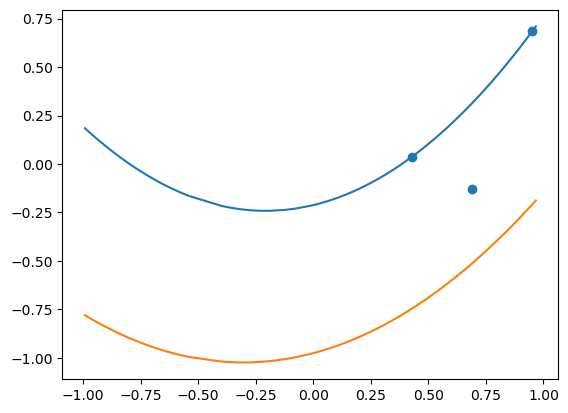

In [994]:
# Normal RANSAC

print(f"outlier is : {outlier}")

size_thresh = 2
best_inlier_size = 0
for subset in subsets:
    LS = linear_model.LinearRegression(fit_intercept=include_bias)
    LS.fit(x[subset, :], y[subset, :])
    y_pred = LS.predict(x)
    inlier = (y_pred - y)**2 <= 0.0
    inlier_size = np.sum(inlier)
    if inlier_size > size_thresh:
        if inlier_size > best_inlier_size:
            best_inlier_size = inlier_size
            best_inlier = inlier
            LS_best = linear_model.LinearRegression(fit_intercept=include_bias) #Ridge(alpha=alpha, fit_intercept=include_bias)
            LS_best.fit(x[best_inlier.reshape(-1), :], y[best_inlier.reshape(-1), :])

print(best_inlier.reshape(-1))

plt.scatter(x_, y)
w, w_ = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
v = w @ theta_true
plt.plot(w_[np.argsort(w_.reshape(-1))], v[np.argsort(w_.reshape(-1))], label='perfect fit')

plt.plot(w_[np.argsort(w_.reshape(-1))], LS_best.predict(w)[np.argsort(w_.reshape(-1))])

In [1017]:
variables = 1
order = 3
include_bias = True
noise = 0.2
m = 4

count = np.array([0, 0])
count_rand = np.array([0, 0])
for i in tqdm(range(1000)):
    x, x_ = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
    n = x.shape[1]
    theta_true = np.random.random((n ,1))*2-1
    y = x @ theta_true

    outlier = np.random.choice(m)
    y[outlier] += np.random.normal(0, noise)

    # get subset of training data
    subsets = list(combinations(list(range(4)), m//2))
    entropy = np.zeros(m)

    # for subset in subsets:
    #     feo = FEO(temperature, L2_regularized=False)
    #     feo.fit(x[subset, :], y[subset, :], fixed_u_star=fixed_u_star, u_star_mul=0.01)
    #     entropy[[subset]] += feo.factor

    size_thresh = 2
    best_inlier_size = 0
    for subset in subsets:
        LS = linear_model.LinearRegression(fit_intercept=include_bias)
        LS.fit(x[subset, :], y[subset, :])
        y_pred = LS.predict(x)
        inlier = (y_pred - y)**2 < 0.001
        inlier_size = np.sum(inlier)
        if inlier_size > size_thresh:
            if inlier_size > best_inlier_size:
                best_inlier_size = inlier_size
                best_inlier = inlier

                entropy = np.zeros(m)    
                entropy[best_inlier.reshape(-1)] = 1 
            elif inlier_size == best_inlier_size: 
                entropy[best_inlier.reshape(-1)] += 1 

    if np.argmin(entropy) == outlier:
        count[0] += 1
    else:
        count[1] += 1
    
    if np.random.choice(m) == outlier:
        count_rand[0] += 1
    else:
        count_rand[1] += 1



100%|██████████| 1000/1000 [00:07<00:00, 125.52it/s]


Text(0, 0.5, 'Probability')

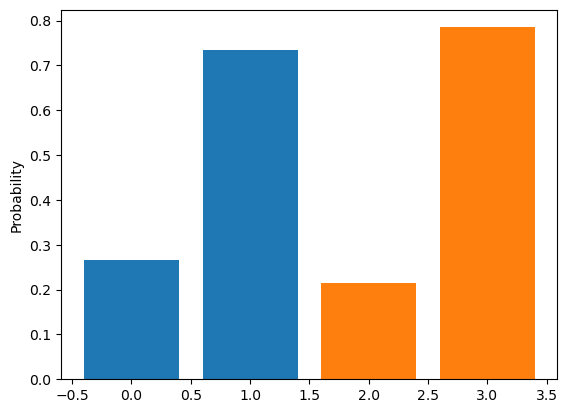

In [1016]:
plt.bar([0,1], count/1000)
plt.bar([2,3], count_rand/1000)
plt.ylabel('Probability')

### Data complexity vs model entropy

In [1038]:
variables = 1
order = 2
include_bias = True
noise = 0.6
m = 5
x, x_ = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
n = x.shape[1]
theta_true = np.random.random((n ,1))*2-1
y = x @ theta_true
y += np.random.normal(0, noise, (m, 1))
#outlier = np.random.choice(m)
#y[outlier] += np.random.normal(0, noise)

x = x[np.argsort(x_.reshape(-1))]
y = y[np.argsort(x_.reshape(-1))]
x_ = x_[np.argsort(x_.reshape(-1))]

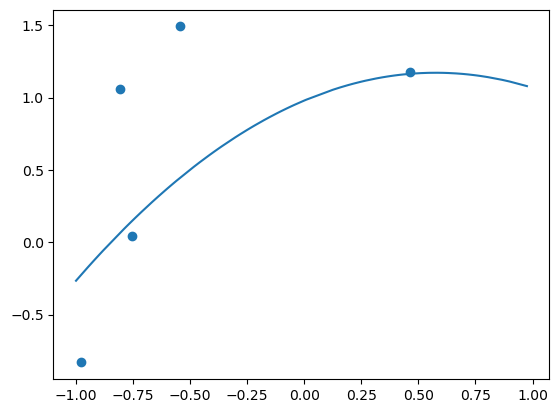

In [1039]:
plt.scatter(x_, y)
w, w_ = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
v = w @ theta_true
plt.plot(w_[np.argsort(w_.reshape(-1))], v[np.argsort(w_.reshape(-1))], label='perfect fit')

In [1071]:
variables = 1
order = 2
include_bias = True
m = 5

replicates = 100
noises = np.arange(0, 0.5, 0.05)
K_complexity = np.zeros((replicates, len(noises)))

for i, replicate in tqdm(enumerate(range(replicates))):
    x, x_ = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
    n = x.shape[1]
    theta_true = np.random.random((n ,1))*2-1
    y_noiseless = x @ theta_true

    for j, noise in enumerate(noises):
        y = y_noiseless + np.random.normal(0, noise, (m, 1))
        x = x[np.argsort(x_.reshape(-1))]
        y = y[np.argsort(x_.reshape(-1))]
        x_ = x_[np.argsort(x_.reshape(-1))]

        for order in range(10):
            poly = PolynomialFeatures(order, include_bias=include_bias)
            x_order = poly.fit_transform(x_)
            LS = linear_model.LinearRegression(fit_intercept=include_bias)
            LS.fit(x_order, y)
            if LS.score(x_order, y) > 0.95:
                break

        #rint(f"Kolmogorov complexity = {order}")
        K_complexity[i, j] = order

        feo = FEO(temperature, L2_regularized=False)
        feo.fit(x, y, fixed_u_star=True, u_star_mul=0.8)

        #print(f"Model entropy = {feo.factor}") 
        # s = feo.factor * feo.u_star**((feo.n-1)/2)
        # entropy.append(s)


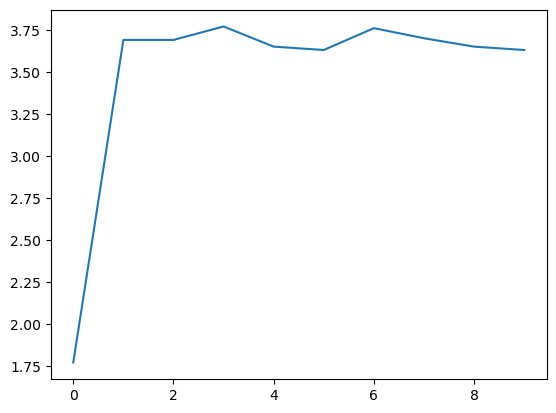

In [1074]:
plt.plot(np.mean(K_complexity, axis=0))

In [1075]:
np.mean(K_complexity, axis=0)

array([1.77, 3.69, 3.69, 3.77, 3.65, 3.63, 3.76, 3.7 , 3.65, 3.63])